<a href="https://colab.research.google.com/github/lcipolina/escher/blob/Lucia/PIL_rotate_shrink_paste_Simone_edits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFilter
from imutils import rotate
import cv2
from imageio import imread


## Setting generic parameters
Rotation, scaling, folders, filenames

In [5]:
ROTATION = 162.497433
SCALING = 0.05576523

# Modify these proportions to account for "masks" in the picture to be pasted in the center!
pasting_added_proportion_x = 1
pasting_added_proportion_y = 1

## Loading the images

In [6]:
#Original escher file
!curl https://i.imgur.com/kzDuHaQ.jpg> original_escher_file.jpg  #We use the the 'Direct Link" in Imgur to download to our local folder in Colab

#Masked file

folder = "/content/"
original_escher_file    = "original_escher_file.jpg"
to_paste_in_center_file = "original_escher_file.jpg" #they are the same....for now

im_original = Image.open(folder + original_escher_file)
im_to_paste = Image.open(folder + to_paste_in_center_file)
im_original = im_original.convert('RGBA')
im_to_paste = im_to_paste.convert('RGBA')


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 57478  100 57478    0     0  1305k      0 --:--:-- --:--:-- --:--:-- 1305k


# 1) Pasting the content in the center to make a "global" picture

## 1.1) Resizing pictures
We need to do two things:
1. Bring both pictures to the same scale of the "original" painting - this is because the scaling factor (0.055..) applies to pictures that are of the same size!
2. Then apply the scaling factor to the picture we want to paste.

### Assumption
Note that in this script we ASSUME that the pictures have the same height. This is why the ratio is calculated starting from the "size[1]" element, which is the height.

In [ ]:
# Note that the ratio is calculated on the basis of height
ratio = SCALING * im_original.size[1]/im_to_paste.size[1]

# PIL only rescales on the basis of a new target pixel size
# So we have to multiply the ratio by the original size, and then cast to integer
new_x = (int)(im_to_paste.size[0] * ratio)
new_y = (int)(im_to_paste.size[1] * ratio)

# Finally, we resize
im_to_paste_scaled = im_to_paste.resize((new_x, new_y), 
                                        Image.ANTIALIAS)


## 1.2) Rotation
This is pretty straightforward, except for a small detail: PIL rotates pictures in a "canvas", which is then filled with colour (the default is black).

So, I have hardcoded the grayish colour of the center of the painting, which is (226, 222, 218) in RGB terms.

P.S.: In theory...the PIL rotate() function should recognize RGBA formats, i.e. with transparency - this is the reason for the extra entry in the tuple (226, 222, 218, 255) - but it doesn't seem to work...

P.P.S.: the "expand = 1" instruction is there to extend the "canvas" when we rotate - otherwise, PIL would just crop the image according to the original dimensions of the picture we rotated!


In [ ]:
#color_for_filling = (226, 222, 218, 255) #colour to use with low-res picture used originally by Simone
color_for_filling = (234, 234, 234, 255) #colour to use with new picture uploaded by Lucia on Imgur
im_to_past_scaled_rotated = im_to_paste_scaled.rotate(-ROTATION, fillcolor=color_for_filling, expand=1)

## 1.3) Pasting
Pasting is done natively by PIL - we just need to provide the (x, y) coordinates of the point in which we want to paste the picture, and we are done.

### Important note
the convention is that we paste the picture from its top-left corner. That is why there is an extra offset below:
1. First we compute the center of the bigger picture ("center_coordinate_x" and "center_coordinate_y")
2. But then we need to SUBTRACT half of the height and the width of the picture we want to paste in order to align the centers

### Assumption
We ASSUME that the centers of the two pictures are the same - this is not correct if the picture to paste is not symmetric, but the error is quite small in this case.

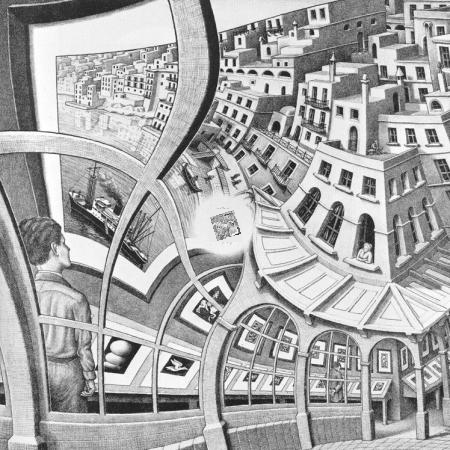

In [ ]:
# Making a copy, to avoid screwing up the original which we will need later!
back_im = im_original.copy()

# Calculating the center coordinate of the bigger picture (the original)
center_coordinate_x = (int)(im_original.size[0]/2)
center_coordinate_y = (int)(im_original.size[1]/2)

# Computing the offsets under the assumption that the center of the pictures are the same
x_offset = (int)(pasting_added_proportion_x * im_to_past_scaled_rotated.size[0]/2)
y_offset = (int)(pasting_added_proportion_y * im_to_past_scaled_rotated.size[1]/2)

# Pasting!
back_im.paste(im_to_past_scaled_rotated, (center_coordinate_x - x_offset, center_coordinate_y - y_offset))

# Saving the picture and opening it up with the default OS utility to open .PNG files
back_im.save('test.png', quality=100)
back_im

# 2) Inverse transformation, i.e. "Zooming in"
Same principles as before apply - except that this time we need to enlarge the "host" picture to zoom in!

## 2.1) Resizing pictures
Note that this time the order of the scaling is reversed! 

And we scale the "original" picture, not the one to paste.

In [ ]:
# Once again, the ratio is calculated on the basis of height
ratio = im_to_paste.size[1]/(SCALING * im_original.size[1])

# But this time we are scaling the original picture to make it bigger (HUGE, in fact)
new_x = (int)(im_original.size[0] * ratio)
new_y = (int)(im_original.size[1] * ratio)

im_to_host_scaled = im_original.resize((new_x, new_y), 
                                        Image.ANTIALIAS)

## 2.2) Rotation
This is exactly as before, except that we are rotating the picture to paste as we loaded it from the file - we are scaling the original painting, remember? 

In [ ]:
im_to_paste_rotated = im_to_paste.rotate(-ROTATION, fillcolor=(226, 222, 218, 255), expand=1)

## 2.3) Pasting
Procedure and assumptions as per 1.3) before - however, we need an additional cropping stage.

This is because the picture we are generating is HUGE - think 9k pixels each side. And also, we are only interested in a zoomed section, right?

So, the PIL "crop()" function is here to help. We need to provide the pixel coordinates for the left, top, right, bottom limits for which we want to crop. Note that for left/right limits we will provide an X coordinate, and for top/bottom we will provide a Y coordinate.

The limits, as you can see below, are determined on the basis of a "crop_factor". Fine-tune it to your preferences, remembering that with 0 you are not cropping anything, and with 0.5 you delete the entire picture!

In [ ]:
# This time, we start from the scaled-up version of the original
back_im = im_to_host_scaled.copy()

# Calculating the center coordinate of the bigger picture (the scaled-up original)
center_coordinate_x = (int)(im_to_host_scaled.size[0]/2)
center_coordinate_y = (int)(im_to_host_scaled.size[1]/2)

# Computing the offsets under the assumption that the center of the pictures are the same
x_offset = (int)(pasting_added_proportion_x * im_to_paste_rotated.size[0]/2)
y_offset = (int)(pasting_added_proportion_y * im_to_paste_rotated.size[1]/2)

# Pasting!
back_im.paste(im_to_paste_rotated, (center_coordinate_x - x_offset, center_coordinate_y - y_offset))

# The resulting picture is huge potentially, so we need to crop.
crop_factor = 0.42

height = back_im.size[1]
width = back_im.size[0]
pixel_to_crop_left = (int)(crop_factor * width)
pixel_to_crop_top = (int)(crop_factor * height)
pixel_to_crop_right = (int)((1 - crop_factor) * width)
pixel_to_crop_bottom = (int)((1 - crop_factor) * height)

back_im = back_im.crop((pixel_to_crop_left, 
                        pixel_to_crop_top, 
                        pixel_to_crop_right, 
                        pixel_to_crop_bottom))

# Saving the picture and opening it up with the default OS utility to open .PNG files
back_im.save('test.png', quality=100)
back_im.show()

(1468, 1468)


## 3) "Reverse zoomed Droste"
I.e., the reference point is the content to paste - everything else rotates around it.

## 3.1) Resizing pictures
This is the very same as 2.1), as we want to zoom in.

In [7]:
# Once again, the ratio is calculated on the basis of height
ratio = im_to_paste.size[1]/(SCALING * im_original.size[1])

# But this time we are scaling the original picture to make it bigger (HUGE, in fact)
new_x = (int)(im_original.size[0] * ratio)
new_y = (int)(im_original.size[1] * ratio)

im_to_host_scaled = im_original.resize((new_x, new_y), 
                                        Image.ANTIALIAS)

## 3.2) Rotation
This time we will rotate the host scaled-up image!

In [8]:
im_host_scaled_and_rotated = im_to_host_scaled.rotate(ROTATION, fillcolor=(226, 222, 218, 255), expand=1)

## 3.3) Pasting
Similar to 2.3) - pasting and cropping.

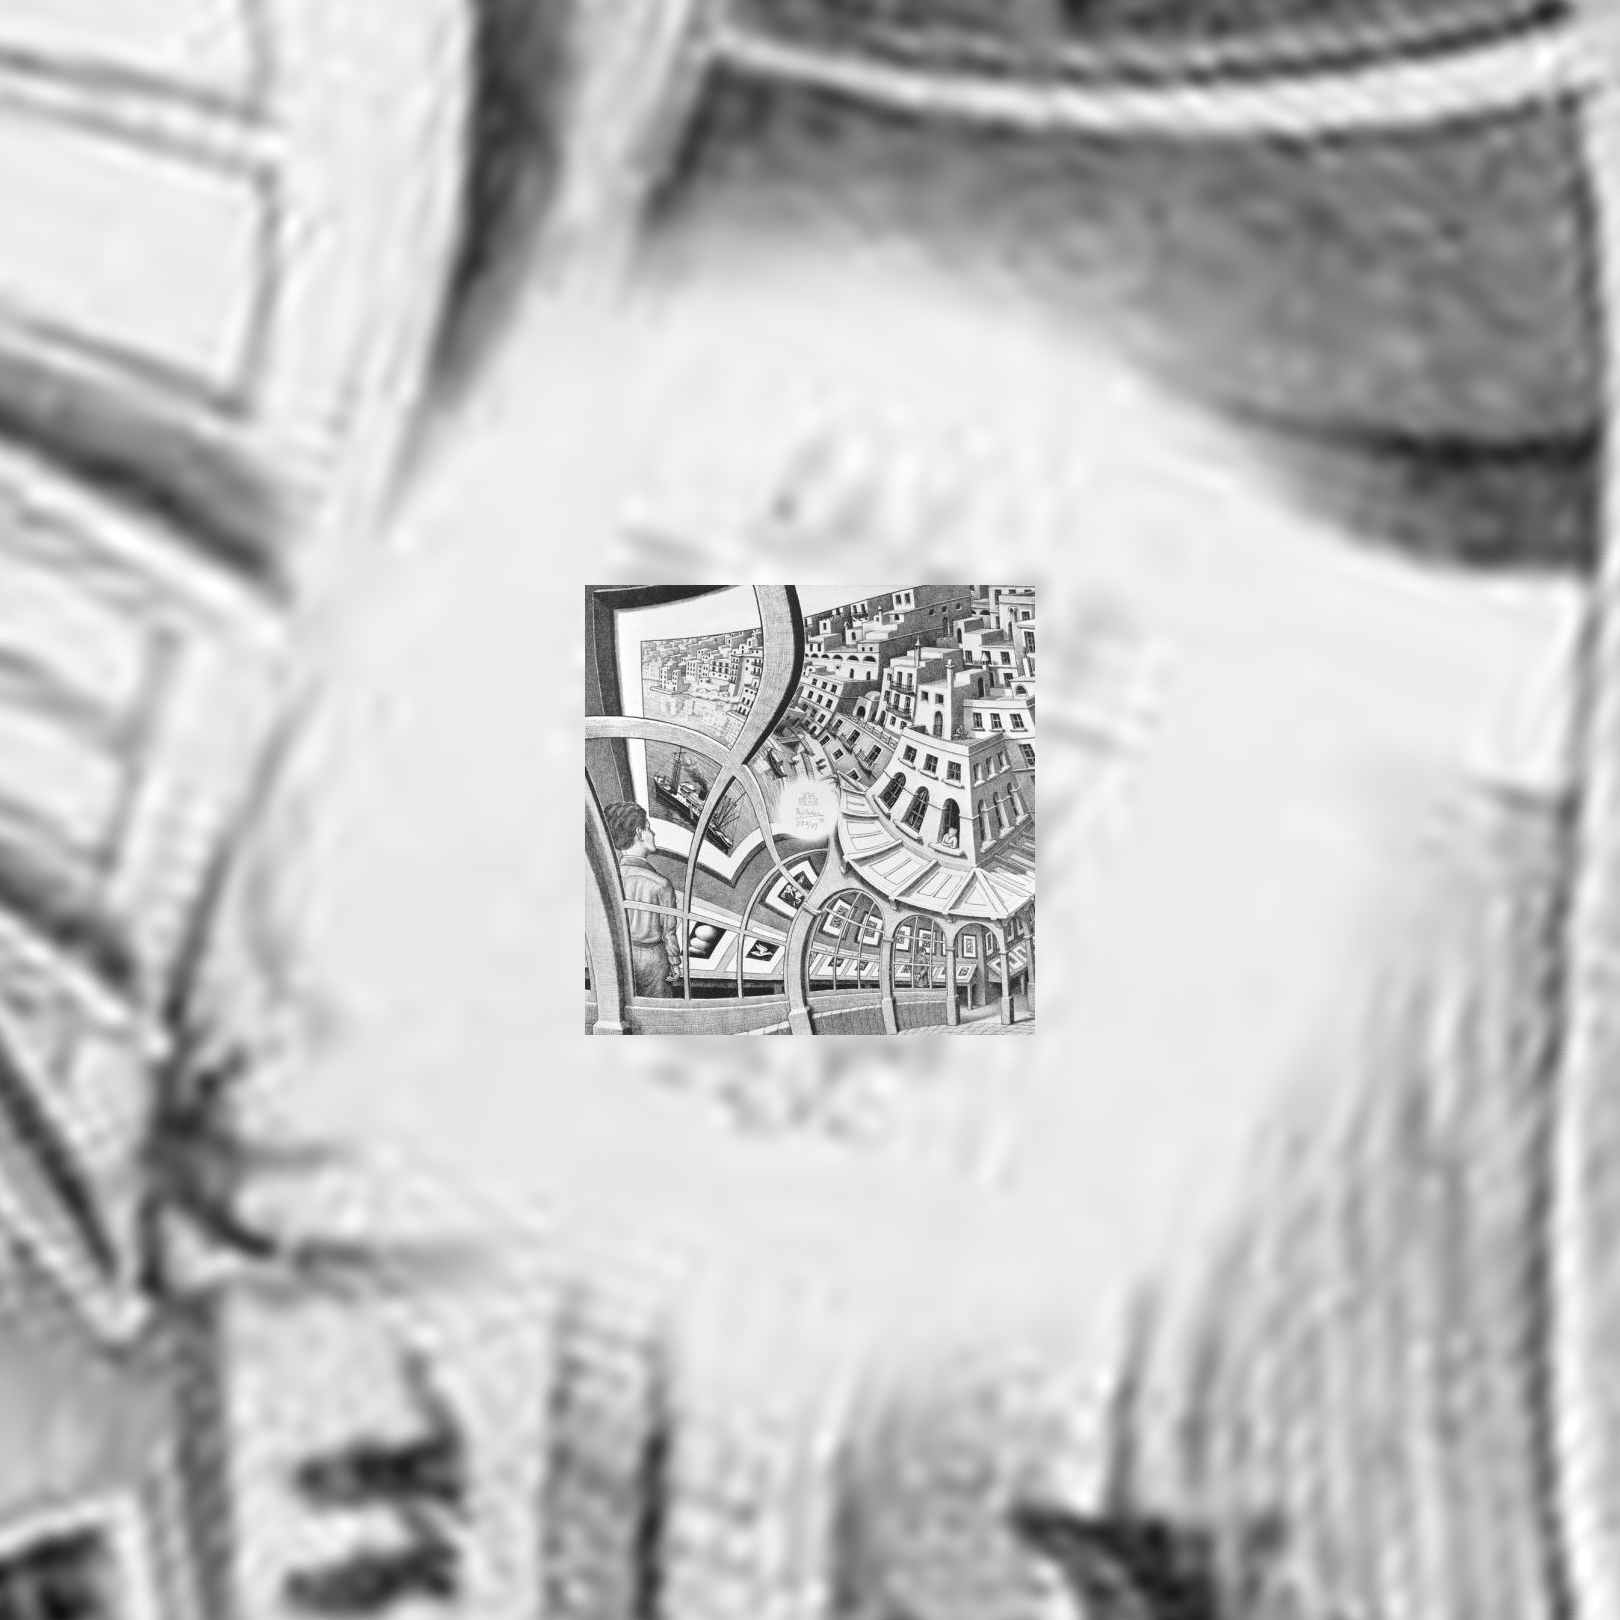

In [10]:
# This time, we start from the scaled-up and rotated version of the original
back_im = im_host_scaled_and_rotated.copy()

# Calculating the center coordinate of the bigger picture (the scaled-up and rotated original)
center_coordinate_x = (int)(im_host_scaled_and_rotated.size[0]/2)
center_coordinate_y = (int)(im_host_scaled_and_rotated.size[1]/2)

# Computing the offsets under the assumption that the center of the pictures are the same
x_offset = (int)(pasting_added_proportion_x * im_to_paste.size[0]/2)
y_offset = (int)(pasting_added_proportion_y * im_to_paste.size[1]/2)

# Pasting!
back_im.paste(im_to_paste, (center_coordinate_x - x_offset, center_coordinate_y - y_offset))

# The resulting picture is huge potentially, so we need to crop.
crop_factor = 0.42

height = back_im.size[1]
width = back_im.size[0]
pixel_to_crop_left = (int)(crop_factor * width)
pixel_to_crop_top = (int)(crop_factor * height)
pixel_to_crop_right = (int)((1 - crop_factor) * width)
pixel_to_crop_bottom = (int)((1 - crop_factor) * height)

back_im = back_im.crop((pixel_to_crop_left, 
                        pixel_to_crop_top, 
                        pixel_to_crop_right, 
                        pixel_to_crop_bottom))

# Saving the picture and opening it up with the default OS utility to open .PNG files
back_im.save('test.png', quality=100)
back_im